# Performances of matrix multiplication on tapered fat trees

In [1]:
library(ggplot2)

plot_results <- function(global_results, local_results){

    communication_times <- local_results[,c("nb_roots", "communication_time")]
    colnames(communication_times) <- c("nb_roots", "time")
    communication_times$group <- "communication"
    computation_times <- local_results[,c("nb_roots", "computation_time")]
    colnames(computation_times) <- c("nb_roots", "time")
    computation_times$group <- "computation"
    global_times <- global_results[,c("nb_roots", "time")]
    global_times$group <- "total"

    all_times = rbind(communication_times, computation_times, global_times)
    
    size <- global_results['size'][1,]
    nb_proc <- global_results['nb_proc'][1,]
    
    title <- paste("Time to perform a matrix product on tapered fat trees\nMatrix size:", size, "\nNumber of processes: ", nb_proc, "\n")
    return(ggplot(all_times, aes(x=nb_roots, y=time, group=group, col=group, fill=group))+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(fun.data = mean_sdl, geom = "errorbar")+
   #     stat_summary(geom="point", fun.y=mean)+
        expand_limits(x=0, y=0)+
        ggtitle(title)
    )
}

We compute a matrix product.

The topology is a 2-level fat-tree made with 48 port switches, where we remove some of the root switches.
In other word, we use fat-trees (2;24,48;1,n;1,1) for n in [1, 24].

The goal with such an experiment is to see if we can make some economies (by removing switches) without losing in performances. This is a similar idea to what was done in the paper “Characterizing Parallel Scientific Applicatioon Commodity Clusters: An Empirical Study of a Tapered Fat-Tre”.

Results obtained with the following command:
```bahsh
./run_measures.py --global_csv global.csv --local_csv local.csv --nb_runs 3 --size 9300 --nb_proc 961 --fat_tree "2;24,48;1,1:24;1,1" --experiment matrix_product
```

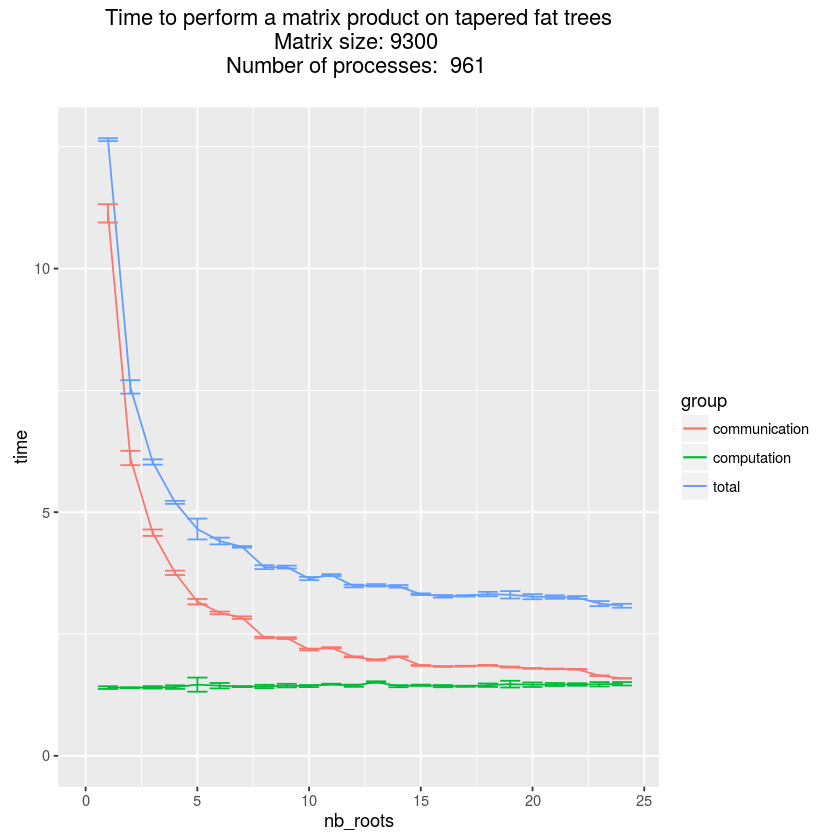

In [2]:
local_results <- read.csv("local.csv")
global_results <- read.csv("global.csv")
plot_results(global_results, local_results)

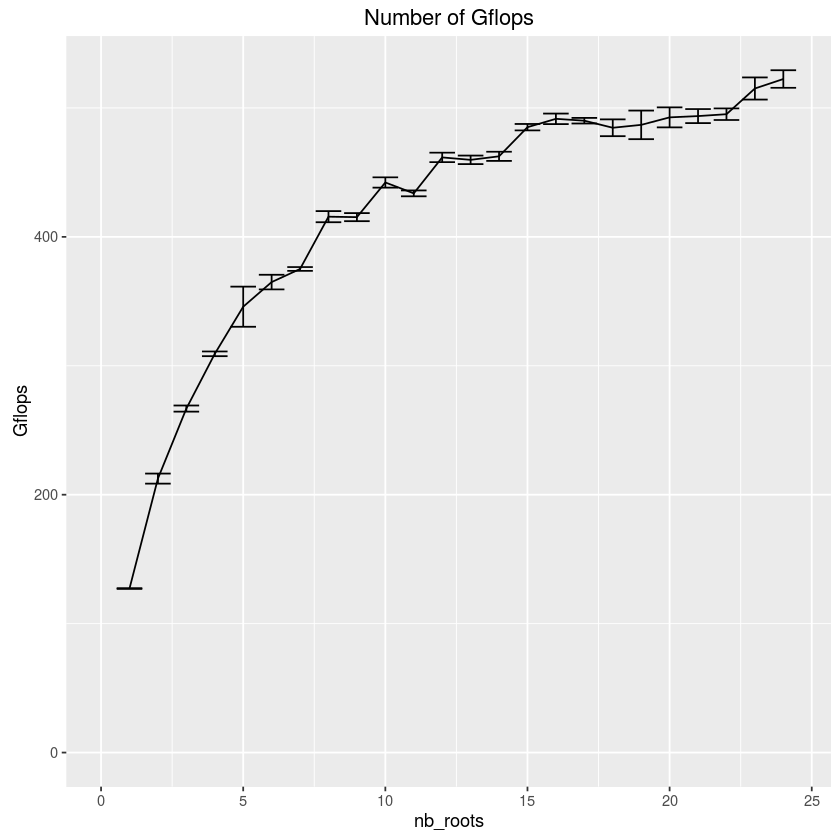

In [3]:
ggplot(global_results, aes(x=nb_roots, y=Gflops))+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(fun.data = mean_sdl, geom = "errorbar")+
        expand_limits(x=0, y=0)+
        ggtitle("Number of Gflops")